In [4]:
import random
import time
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import tz
import matplotlib.pyplot as plt

### Utility Functions

In [5]:
def create_tuple(response):
    response_data = response.json()
    response_datum = response_data[0]
    response_target = response_datum['target']
    response_datapoints = response_datum['datapoints']
    tuple_array = [tuple(x) for x in response_datapoints]
    npa = np.array(tuple_array, dtype=[
        ('value', np.double), ('ts', 'datetime64[ms]')])
    return npa

def fume_query(target,server, start,end):
  url = "https://ypsu0n34jc.execute-api.us-east-1.amazonaws.com/dev/query"
  data = {
      "range": {
        "from": start,
        "to": end,
      },
      "targets": [
        {
          "payload": {
            "schema": server,
          },
          "target": target
        }
      ],

    }
  request = requests.post(url, json=data)
  print(request)
  # print(request.json())
  return create_tuple(request)


def query_to_list(point, server, start, end):
    master = fume_query(point, server, start, end)

    list = pd.Series(data=[i[0] for i in master], index=[i[1] for i in master])
    # print("\n", point, "\n", list)

    list = list[~list.index.duplicated()]
    # print("\n", point, " new\n", list)

    return list

### Insert into Database Function

In [15]:
# the x-api-key is the secret authentication to allow posting updates
headers = {"x-api-key": "LfSpEZ3woOuljzb2EAg0"}
# the endpoint URL for trend updates
TREND_API_URL = "https://7zhs2wplt9.execute-api.us-east-1.amazonaws.com/dev/trend"
# time in seconds that the request will timeout if no response is received.
# the API will only run for 6 seconds, so if it can't process
# the data posted in that amount of time it will fail.
API_TIMEOUT = 30

# timestamps
now = int(time.time())
last_hour = now - now % 3600
start_time = last_hour - (3600 * 6)

def insert_into_database(pseudo_point, data):
    # data = [compute_value(point, ts) for ts in range(start_time, last_hour, 3600)]
    data = np.fliplr(data.reset_index().to_numpy()).tolist()
    print(data)

    json_obj = {"object_name": pseudo_point, "data": data }
    # e.g.
    # { "object_name": "Biotech.GroundFloor.Lab_g54.Hood_1.energy.occ",
    # "data": [[0, 1681462800], [0, 1681466400], [0, 1681470000], [4.430475, 1681473600]],
    # }
    req_start = time.time()
    response = requests.post(TREND_API_URL, json=json_obj, headers=headers, timeout=API_TIMEOUT)
    req_end = time.time()
    r = response.json()
    print(f"""received status_code:{response.status_code} msg:{r.get('message', None)}
    rows:{r.get('affectedRows', None)} duplicates:{r.get('duplicates', None)} 
    for point:{pseudo_point} with id:{r.get('obj_id', None)} in {req_end-req_start:.3f} seconds.""")

### Metrics Functions

In [16]:
def total_time_sash_open(sash_point, occ_point, server, start, end, is_occupied):
  sash_list = query_to_list(sash_point, server, start, end)
  occ_list = query_to_list(occ_point, server, start, end)

  df = pd.concat([sash_list, occ_list], axis=1)
  df.columns = ["sash", "occ"]
  # display(df)

  time_interval = df.index[1].minute - df.index[0].minute
  # print("Time interval", time_interval)

  # from running the above on a large time difference, 1.2 inches is the most common smallest value
  df["time_open_mins"] = np.where((df["sash"] > 1.2), time_interval, 0)

  df = df.dropna()
  df.index = df.index.map(lambda x: x.to_pydatetime().replace(tzinfo=tz.tzutc()).astimezone(tz.tzlocal()))
  # display(df)

  df = df[df['occ']==int(is_occupied)]
  # display(df)

  df = df.groupby(pd.Grouper(freq='60Min', label='right')).sum()
  df.index = df.index.strftime('%s').astype("int")
  display(df)

  return df["time_open_mins"]

In [17]:
# Arguments: CFM Point, Sash Point, Occ Point, Internal Temp Point, External Temp Point, Server Name, Start Time, End Time
# Returns: Total energy from hume hood, aggregated by hour.

# A switch in the energy calculations that allows us to avoid issues between times of years where it is hotter/colder outside.
def coldorhot(cfm, external, internal, time_interval):
    if external<=internal:
        #sensible heating equation
        return 1.08 * cfm * (internal - external) / (60 / time_interval)
    if external>internal:
        #enthalpy of air
        return 0.24 * cfm /13.333 * 60 * (external - internal) / (60 / time_interval)

def total_energy(cfm_point, sash_point, occ_point, internal_temp_point, external_temp_point, server, start, end, is_occupied):
  #external_temp_master = outside_temp(start,end)
  cfm_list = query_to_list(cfm_point, server, start, end)
  sash_list = query_to_list(sash_point, server, start, end)
  occ_list = query_to_list(occ_point, server, start, end)
  internal_temp_list = query_to_list(internal_temp_point, server, start, end)
  external_temp_list = query_to_list(external_temp_point, server, start, end)

  df = pd.concat([cfm_list, sash_list, occ_list, internal_temp_list, external_temp_list], axis=1)
  df.columns = ["cfm", "sash", "occ", "internal_temp", "external_temp"]
  display(df)

  df["external_temp"] = df["external_temp"].interpolate()
  display(df)
  
  time_interval = df.index[1].minute - df.index[0].minute

  df['BTU'] = df.apply(lambda df: coldorhot(df['cfm'], df['external_temp'], df['internal_temp'], time_interval=time_interval), axis=1)
  df.index = df.index.map(lambda x: x.to_pydatetime().replace(tzinfo=tz.tzutc()).astimezone(tz.tzlocal()))
  display(df)

  df = df[df['occ']==int(is_occupied)]

  df = df.groupby(pd.Grouper(freq='60Min', label='right')).sum()
  df.index = df.index.strftime('%s').astype("int")
  display(df)

  return df["BTU"]

TODO
1. Load the namingconvention.csv to obtain the structure of biotech along with all points
2. For each row (fume hood) of the csv, pass the point names into the queries.  For example, pass the point names for the current hood to calculate a total_time_sash_open for that hood (do this for occ and unocc).  Do this for both the sash open and energy metrics.
3. After doing this, also for each row, insert the data into Steve's database using the correct pseudo-point name (the last four rows of the csv)

- Start this at the beginning of 2023


In [18]:
sash_data_occ = total_time_sash_open(sash_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash",
                                     occ_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
                                     server="biotech_main",
                                     start=str(datetime(2023, 1, 1)),
                                     end=str(datetime.now()),
                                     is_occupied=True)

sash_data_unocc = total_time_sash_open(sash_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash",
                                       occ_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
                                       server="biotech_main",
                                       start=str(datetime(2023, 1, 1)),
                                       end=str(datetime.now()),
                                       is_occupied=False)

energy_data_occ = total_energy(cfm_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hoodvalve_flow/trend_log",
                               sash_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash",
                               occ_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
                               internal_temp_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log",
                               external_temp_point="#biotech/ground_flr_mech/building_hydronic_heating_syatems/reheat_heat_exchanger/oat",
                               server="biotech_main",
                               start=str(datetime(2023, 1, 1)),
                               end=str(datetime.now()),
                               is_occupied=True)

energy_data_unocc = total_energy(cfm_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hoodvalve_flow/trend_log",
                                 sash_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/hood_sash",
                                 occ_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/occ_trend",
                                 internal_temp_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_433_control/zone/zone_temp/trend_log",
                                 external_temp_point="#biotech/ground_flr_mech/building_hydronic_heating_syatems/reheat_heat_exchanger/oat",
                                 server="biotech_main",
                                 start=str(datetime(2023, 1, 1)),
                                 end=str(datetime.now()),
                                 is_occupied=False)

insert_into_database(
    "Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.occ", sash_data_occ)
insert_into_database(
    "Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.unocc", sash_data_unocc)
insert_into_database(
    "Biotech.Floor_4.Lab_433.Hood_1.energy.occ", energy_data_occ)
insert_into_database(
    "Biotech.Floor_4.Lab_433.Hood_1.energy.unocc", energy_data_unocc)

# a list of points
points = [
    # "Biotech.Floor_4.Lab_433.Hood_1.energy.occ",
    # "Biotech.Floor_4.Lab_433.Hood_1.energy.unocc",
    # "Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.occ",
    "Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.unocc",
    # "Biotech.GroundFloor.Lab_g54.Hood_1.energy.unocc",
    # "Biotech.GroundFloor.Lab_g54.Hood_1.sashOpenTime.occ",
]


<Response [200]>
<Response [200]>


,sash,occ,time_open_mins
1672603200,1.2,1.0,0
1672606800,6.0,5.0,0
1672610400,0.0,0.0,0
1672614000,0.0,0.0,0
1672617600,0.0,0.0,0
...,...,...,...
1683104400,0.0,0.0,0
1683108000,0.0,0.0,0
1683111600,4.8,4.0,0
1683115200,14.4,12.0,0


<Response [200]>
<Response [200]>


,sash,occ,time_open_mins
1672552800,14.4,0.0,0
1672556400,14.4,0.0,0
1672560000,14.4,0.0,0
1672563600,14.4,0.0,0
1672567200,14.4,0.0,0
...,...,...,...
1683097200,14.4,0.0,0
1683100800,14.4,0.0,0
1683104400,14.4,0.0,0
1683108000,14.4,0.0,0


<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


,cfm,sash,occ,internal_temp,external_temp
2023-01-01 05:00:00,222.66,1.2,0.0,68.1,52.0
2023-01-01 05:05:00,221.69,1.2,0.0,68.1,NaN
2023-01-01 05:10:00,227.55,1.2,0.0,68.1,NaN
2023-01-01 05:15:00,221.20,1.2,0.0,68.1,51.9
2023-01-01 05:20:00,222.17,1.2,0.0,68.1,NaN
...,...,...,...,...,...
2023-05-03 14:30:00,NaN,NaN,1.0,NaN,44.1
2023-05-03 14:35:00,NaN,NaN,1.0,NaN,NaN
2023-05-03 14:40:00,NaN,NaN,1.0,NaN,NaN
2023-05-03 14:45:00,NaN,NaN,1.0,NaN,43.7


,cfm,sash,occ,internal_temp,external_temp
2023-01-01 05:00:00,222.66,1.2,0.0,68.1,52.000000
2023-01-01 05:05:00,221.69,1.2,0.0,68.1,51.966667
2023-01-01 05:10:00,227.55,1.2,0.0,68.1,51.933333
2023-01-01 05:15:00,221.20,1.2,0.0,68.1,51.900000
2023-01-01 05:20:00,222.17,1.2,0.0,68.1,51.833333
...,...,...,...,...,...
2023-05-03 14:30:00,NaN,NaN,1.0,NaN,44.100000
2023-05-03 14:35:00,NaN,NaN,1.0,NaN,43.966667
2023-05-03 14:40:00,NaN,NaN,1.0,NaN,43.833333
2023-05-03 14:45:00,NaN,NaN,1.0,NaN,43.700000


,cfm,sash,occ,internal_temp,external_temp,BTU
2023-01-01 00:00:00-05:00,222.66,1.2,0.0,68.1,52.000000,322.63434
2023-01-01 00:05:00-05:00,221.69,1.2,0.0,68.1,51.966667,321.89388
2023-01-01 00:10:00-05:00,227.55,1.2,0.0,68.1,51.933333,331.08525
2023-01-01 00:15:00-05:00,221.20,1.2,0.0,68.1,51.900000,322.50960
2023-01-01 00:20:00-05:00,222.17,1.2,0.0,68.1,51.833333,325.25688
...,...,...,...,...,...,...
2023-05-03 10:30:00-04:00,NaN,NaN,1.0,NaN,44.100000,NaN
2023-05-03 10:35:00-04:00,NaN,NaN,1.0,NaN,43.966667,NaN
2023-05-03 10:40:00-04:00,NaN,NaN,1.0,NaN,43.833333,NaN
2023-05-03 10:45:00-04:00,NaN,NaN,1.0,NaN,43.700000,NaN


,cfm,sash,occ,internal_temp,external_temp,BTU
1672603200,222.66,1.2,1.0,69.9,45.033333,498.31308
1672606800,1128.44,6.0,5.0,350.8,225.833333,2538.31326
1672610400,0.00,0.0,0.0,0.0,0.000000,0.00000
1672614000,0.00,0.0,0.0,0.0,0.000000,0.00000
1672617600,0.00,0.0,0.0,0.0,0.000000,0.00000
...,...,...,...,...,...,...
1683111600,900.90,4.8,4.0,281.2,167.866667,2297.39013
1683115200,2692.46,14.4,12.0,861.0,502.800000,7232.92698
1683118800,1348.18,7.2,12.0,433.4,509.800000,3617.64966
1683122400,0.00,0.0,12.0,0.0,510.000000,0.00000


<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


,cfm,sash,occ,internal_temp,external_temp
2023-01-01 05:00:00,222.66,1.2,0.0,68.1,52.0
2023-01-01 05:05:00,221.69,1.2,0.0,68.1,NaN
2023-01-01 05:10:00,227.55,1.2,0.0,68.1,NaN
2023-01-01 05:15:00,221.20,1.2,0.0,68.1,51.9
2023-01-01 05:20:00,222.17,1.2,0.0,68.1,NaN
...,...,...,...,...,...
2023-05-03 14:30:00,NaN,NaN,1.0,NaN,44.1
2023-05-03 14:35:00,NaN,NaN,1.0,NaN,NaN
2023-05-03 14:40:00,NaN,NaN,1.0,NaN,NaN
2023-05-03 14:45:00,NaN,NaN,1.0,NaN,43.7


,cfm,sash,occ,internal_temp,external_temp
2023-01-01 05:00:00,222.66,1.2,0.0,68.1,52.000000
2023-01-01 05:05:00,221.69,1.2,0.0,68.1,51.966667
2023-01-01 05:10:00,227.55,1.2,0.0,68.1,51.933333
2023-01-01 05:15:00,221.20,1.2,0.0,68.1,51.900000
2023-01-01 05:20:00,222.17,1.2,0.0,68.1,51.833333
...,...,...,...,...,...
2023-05-03 14:30:00,NaN,NaN,1.0,NaN,44.100000
2023-05-03 14:35:00,NaN,NaN,1.0,NaN,43.966667
2023-05-03 14:40:00,NaN,NaN,1.0,NaN,43.833333
2023-05-03 14:45:00,NaN,NaN,1.0,NaN,43.700000


,cfm,sash,occ,internal_temp,external_temp,BTU
2023-01-01 00:00:00-05:00,222.66,1.2,0.0,68.1,52.000000,322.63434
2023-01-01 00:05:00-05:00,221.69,1.2,0.0,68.1,51.966667,321.89388
2023-01-01 00:10:00-05:00,227.55,1.2,0.0,68.1,51.933333,331.08525
2023-01-01 00:15:00-05:00,221.20,1.2,0.0,68.1,51.900000,322.50960
2023-01-01 00:20:00-05:00,222.17,1.2,0.0,68.1,51.833333,325.25688
...,...,...,...,...,...,...
2023-05-03 10:30:00-04:00,NaN,NaN,1.0,NaN,44.100000,NaN
2023-05-03 10:35:00-04:00,NaN,NaN,1.0,NaN,43.966667,NaN
2023-05-03 10:40:00-04:00,NaN,NaN,1.0,NaN,43.833333,NaN
2023-05-03 10:45:00-04:00,NaN,NaN,1.0,NaN,43.700000,NaN


,cfm,sash,occ,internal_temp,external_temp,BTU
1672552800,2685.14,14.4,0.0,816.2,620.600000,3939.09594
1672556400,2685.63,14.4,0.0,812.6,608.300000,4115.10078
1672560000,2688.08,14.4,0.0,816.6,579.200000,4786.22577
1672563600,2687.57,14.4,0.0,822.9,559.600000,5306.86974
1672567200,2683.66,14.4,0.0,823.2,542.400000,5651.84976
...,...,...,...,...,...,...
1683097200,2693.93,14.4,0.0,854.5,513.300000,6893.80209
1683100800,2691.49,14.4,0.0,849.0,510.300000,6836.95788
1683104400,2695.88,14.4,0.0,846.7,508.000000,6848.25375
1683108000,2691.49,14.4,0.0,844.5,505.300000,6847.10958


[[0, 1672603200], [0, 1672606800], [0, 1672610400], [0, 1672614000], [0, 1672617600], [0, 1672621200], [0, 1672624800], [0, 1672628400], [0, 1672632000], [0, 1672635600], [0, 1672639200], [0, 1672642800], [0, 1672646400], [0, 1672650000], [0, 1672653600], [0, 1672657200], [0, 1672660800], [0, 1672664400], [0, 1672668000], [0, 1672671600], [0, 1672675200], [0, 1672678800], [0, 1672682400], [0, 1672686000], [0, 1672689600], [0, 1672693200], [0, 1672696800], [0, 1672700400], [0, 1672704000], [0, 1672707600], [0, 1672711200], [0, 1672714800], [0, 1672718400], [0, 1672722000], [0, 1672725600], [0, 1672729200], [0, 1672732800], [0, 1672736400], [0, 1672740000], [0, 1672743600], [0, 1672747200], [0, 1672750800], [0, 1672754400], [0, 1672758000], [0, 1672761600], [0, 1672765200], [0, 1672768800], [0, 1672772400], [0, 1672776000], [0, 1672779600], [0, 1672783200], [0, 1672786800], [0, 1672790400], [0, 1672794000], [0, 1672797600], [0, 1672801200], [0, 1672804800], [0, 1672808400], [0, 167281200

<Response [200]>
<Response [200]>


,occ,unocc
2023-04-22 01:00:00-04:00,0.0,0.0
2023-04-22 02:00:00-04:00,0.0,0.0
2023-04-22 03:00:00-04:00,0.0,0.0
2023-04-22 04:00:00-04:00,0.0,0.0
2023-04-22 05:00:00-04:00,0.0,0.0
...,...,...
2023-05-02 10:00:00-04:00,0.0,0.0
2023-05-02 11:00:00-04:00,0.0,0.0
2023-05-02 12:00:00-04:00,0.0,0.0
2023-05-02 13:00:00-04:00,0.0,0.0


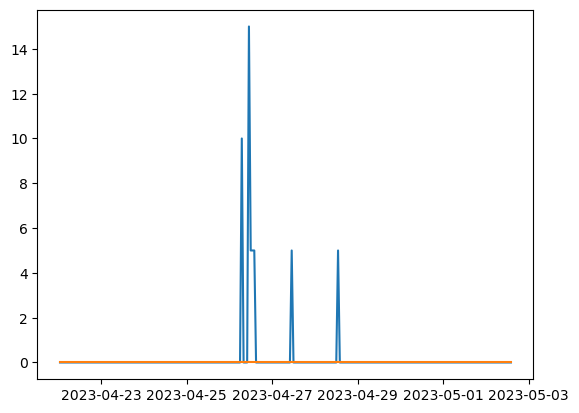

In [36]:
def synthetic_query(target, start, end):
    url = "https://portal.emcs.cornell.edu/api/datasources/proxy/5/query"
    data = {
        "range": {
            "from": start,
            "to": end,
        },
        "targets": [
            {
                "target": target
            }
        ],

    }
    request = requests.post(url, json=data)
    print(request)
    # print(request.json())
    master = create_tuple(request)
    list = pd.Series(data=[i[0] for i in master],
                     index=[i[1] for i in master])

    list = list[~list.index.duplicated()]

    return list

sash_data_occ = synthetic_query(target="Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.occ",
                                    start=str(datetime(2023, 4, 22)),
                                    end=str(datetime.now()))

sash_data_unocc = synthetic_query(target="Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.unocc",
                                      start=str(datetime(2023, 4, 22)),
                                      end=str(datetime.now()))

final_df = pd.DataFrame(
        data={"occ": sash_data_occ, "unocc": sash_data_unocc})
final_df = final_df.fillna(0)
final_df.index = final_df.index.map(lambda x: x.to_pydatetime().replace(tzinfo=tz.tzutc()).astimezone(tz.tzlocal()))
display(final_df)
plt.plot(final_df)